## Lecture 3: Root finding, Interpolation and Continuous optimization

This lecture is inspired by a question from Minnesota Alumnus [Kim Ruhl](https://kimjruhl.com/), who is a coding enthusiast who was new to Julia. In response, I provided this brief introduction to optimization in Julia.

In this lecture and the third assignment, we will build towards solving standard dynamic programming problems in economics with ```continuous optimization methods```. If you recall from the second lecture, given capital $k$, we search on a discrete grid of $k'$ for the one that maximizes the right hand side of the Bellman equation. This method is referred to as ```grid search```. While intuitive and straightforward, grid search has inherent limitations. Given each state today, the optimal $k'$ to choose will, in general, lie somewhere between grids of $k$. For example, fixing a grid of $k'$ (say 100 grids between 0 to 10), given a state $k$, the optimal $k'$ to choose might be, say, $3.875$, which lies between the two grids we specify: $3.8$ and $3.9$. With the grid search method, $k'$ will be assigned to be either one of the two and we will update the value function based on that. Note that we are losing precisions of our policy function and value function as a better guess shall be directly using $k' = 3.875$. Poor precisions can cause quantitative biases and make the results of the model less reliable and robust. 

Continuous optimization methods offer a powerful alternative by allowing us to directly pinpoint the optimal value. But the advantages of continuous optimization go beyond mere precision. These methods exploit sophisticated numerical properties and algorithms that significantly accelerate the computation process. For example, techniques such as gradient descent, Newton-Raphson, and quasi-Newton methods are designed to efficiently navigate the complex landscape of the optimization problem, converging to the optimal solution much faster than traditional methods.

In the realm of economics, many models feature continuous choice variables, such as investment, consumption and labor supply. Continuous optimization methods are particularly well-suited for these models, as they can seamlessly handle the continuous nature of the decision variables, providing more accurate and reliable results. In these scenarios, continuous methods are usually the go-to method. 

However, it is important to recognize that continuous optimization methods come with their own set of challenges. These methods often rely on assumptions about the smoothness and differentiability of the objective function, which may not always hold in practice. Additionally, they can be sensitive to the initial conditions and parameter choices, sometimes leading to convergence issues or local optima traps. As we delve deeper into these methods, we will explore strategies to mitigate these challenges, ensuring that we can harness their full potential.

### 1. A simple root-finding problem

You might or might not have heard or used [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method) before. Named after Isaac Newton and Joseph Raphson, it is probably the most famous root-finding algorithm which produces successively better approximations to the roots (or zeroes) of a real-valued function.

The idea of it is very simple: we start with an initial guess, then to approximate the function by its tangent line, and finally to compute the x-intercept of this tangent line. This will often be a better approximation to the original function's root than the first guess, and the method can be iterated.

The tangent line to the curve $f(x)$ at $x = x_n$ intercepts the x-axis at $x_{n+1}$, then by definition the slope is
$$
f'(x_n) = \frac{f(x_n) - 0}{x_n - x_{n+1}}
$$

Solving for $x_{n+1}$ gets us, 
$$
x_{n+1}= x_n -  \frac{f(x_n)}{f'(x_n)}
$$

Start with some initial guess $x_0$, we can iterate until convergence, where we obtain the root.

But what does this have to do with optimization? Root finding and optimization problems are actually of great mathematical resemblance. Think of the first thing you do with a (well-behaved) optimization problem. You take first order conditions! You get a function, say $g'(x) = 0$, which is exactly a root-finding problem.

Now, before resorting to any pre-written solvers, let's do this very simple algorithm by hand to see how it works and get a sense of success before becoming hand-wavy and let solves do our jobs later on.

In [1]:
import Pkg
Pkg.activate(".")  # Activate a local environment 

  Activating project at `~/Documents/Teaching/Julia course 2024/Julia/Lectures`


In [2]:
using Plots # add the Plots package if you don't have it yet.
using LinearAlgebra

The goal is to find the root of a function $f(x, p) = 0$, where $x$ is the independent variable and $p$ are some parameters. We will consider where $p$ is some general vectors.

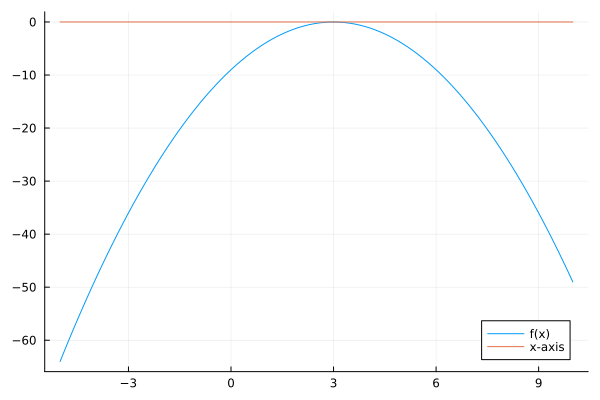

In [3]:
# A simple function of one variable and one parameter
f(x, p) = -(x .- p) .^ 2;

x = range(-5, 10, length=100);
fx = f(x, 3);
plot(x, fx, label = "f(x)")
plot!(x, zeros(size(x)), label = "x-axis")

Obviously the function has a single root that equals to $p$ (here 3).

Let's write down the Newton method to do this.

Here this is just illustrative but for good practices of code, you shall always avoid using global variables and wrap the parameters into a struct (we have seen in lecture 2) or using a named tuple (defined below). Here due to the simplicity of our problem, this is not really a necessity.

In [9]:
"""
Create an instance of the model, stored as a named tuple.

"""
function create_showcase_model(; xmin = -10.0, #beware of type
                                 xmax = 10.0,
                                 nx = 100,
                                 p = [3.0, 4.0])
        x_grid = LinRange(xmin, xmax, nx)
        f(x, p) = - (x .- p) .^ 2  #you can define functions in named tuples
        return (; x_grid, f, p, nx)
end

create_showcase_model

In [10]:
# create the tuple 
model = create_showcase_model()

# want to change some parameter? You can do create_showcase_model(p = 4.0)

(x_grid = LinRange{Float64}(-10.0, 10.0, 100), f = var"#f#20"(), p = [3.0, 4.0], nx = 100)

In [11]:
# calling something from the tuple is exactly same as struct
model.p

2-element Vector{Float64}:
 3.0
 4.0

The key here is for Newton Method we need analytical or numerical derivative of the function. For functions (or systems) that have an analytical form, you can automatically compute the first derivative by using the ```ForwardDiff``` package. You can think of what the package does is to use the known differential laws (like the chain rule) to efficiently solve for analytical derivatives directly. It really works like magic.

``` 
    fp = x -> f(x,p) # change f into a one input funcion
    autodiff(fp) = x -> ForwardDiff.jacobian(fp, x) # automatic differentiation of f on x
```
(Note: For a single output function, simply use ```ForwardDiff.derivative```. Here since I made f multi-variable. I use ```ForwardDiff.jacobian``` instead. )
    
Then I use ```fp``` and ```autodiff(fp)``` to get the Jacobian at our guesses and update it with the standard Newton method rule. 

In [12]:
# Import the package to perform automatic differentiation (you might need to Pkg.add this)
using ForwardDiff

In [13]:
function Newton(f;p = model.p, tol = 1e-8, maxiter = 1000)
    x0 = zeros(eltype(p), length(p)) #initial guesses at 0.0
    x1 = similar(x0)
    fp = x -> f(x,p) # change f into a one input funcion
    # automatic differentiation of f
    autodiff(fp) = x -> ForwardDiff.jacobian(fp, x)
    
    iter = 0
    error = 1.0
    while (error > tol && iter < maxiter)
        # not the most efficient but clear
        J = autodiff(fp)(x0) 
        x1 = x0 .- J\fp(x0) #or use a linear solver
        error = maximum(abs.(x1 - x0))
        iter += 1
        x0 .= x1
    end

    return x1
end


Newton (generic function with 1 method)

In [14]:
Newton(model.f)

2-element Vector{Float64}:
 2.9999999944120646
 3.9999999925494194

In [15]:
using BenchmarkTools # package for seeing system details of code running

In [16]:
@benchmark Newton(model.f)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  56.542 μs …  2.575 ms  ┊ GC (min … max): 0.00% … 95.74%
 Time  (median):     58.250 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   61.125 μs ± 70.074 μs  ┊ GC (mean ± σ):  3.18% ±  2.71%

     ▄▆██▁                                                     
  ▂▄▆█████▆▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  56.5 μs         Histogram: frequency by time          72 μs <

 Memory estimate: 36.55 KiB, allocs estimate: 672.

This is an idea of what is behind the nonlinear solvers of Julia. Of course they further optimized the code to make it more efficient. 

Now we use the ```NLsolve``` package. The naive implementation of it uses numerical Jacobian by [finite differencing](https://en.wikipedia.org/wiki/Finite_difference_method). The idea is to use the first order Taylor expansion to approximate the derivative. Note that here it does not require the function to have an analytical derivative. 



In [17]:
using NLsolve

In [18]:
p = [3.0, 4.0]
fp = x -> model.f(x,p) # change f into a one input funcion
# Newton method with numerical Jacobian by finite differencing
nlsolve(fp, [0.0, 0.0]) #[0.0, 0.0] is the initial guess

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [2.999945851229831, 3.9999278016397692]
 * Inf-norm of residuals: 0.000000
 * Iterations: 19
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 20
 * Jacobian Calls (df/dx): 20

In [19]:
@benchmark nlsolve(fp, [0.0, 0.0]) 

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  35.917 μs …  2.868 ms  ┊ GC (min … max): 0.00% … 97.37%
 Time  (median):     37.083 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   39.754 μs ± 78.867 μs  ┊ GC (mean ± σ):  5.54% ±  2.75%

       ▃█▄█▂▆▁▄▂                                               
  ▁▁▂▄▅█████████▅▅▃▄▃▃▃▂▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  35.9 μs         Histogram: frequency by time        42.2 μs <

 Memory estimate: 38.47 KiB, allocs estimate: 518.

As you can see, even with numerical differencing, it takes less than half of the time of the version I wrote down.

How about we also use auto differentiation in ```NLsolve```?

In [20]:
# since we have analytical f here, we can use autodiff
@benchmark nlsolve(fp, [0.0, 0.0], autodiff = :forward)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  21.750 μs …  3.087 ms  ┊ GC (min … max): 0.00% … 97.40%
 Time  (median):     22.855 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.807 μs ± 58.908 μs  ┊ GC (mean ± σ):  4.68% ±  1.96%

    █▆                                                         
  ▂▅███▇▆▆▄▄▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂ ▃
  21.8 μs         Histogram: frequency by time          35 μs <

 Memory estimate: 20.77 KiB, allocs estimate: 258.

Note that auto-differentiation provides better performance (more than 30% here). 

If you like algebra, you can also manually inputting the derivatives:

In [21]:
fprime(x, p) =  -2.0 * x .+ 2.0 .* p # analytical derivative
p = [3.0, 4.0]
fprime_p = x -> Diagonal(fprime(x, p)) #to create correct Jacobian

#29 (generic function with 1 method)

In [22]:
nlsolve(fp, fprime_p, [0.0, 0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [2.9999458512298305, 3.9999278016397737]
 * Inf-norm of residuals: 0.000000
 * Iterations: 19
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 20
 * Jacobian Calls (df/dx): 20

In [23]:
@benchmark nlsolve(fp, fprime_p, [0.0, 0.0])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  20.292 μs …  3.155 ms  ┊ GC (min … max): 0.00% … 97.59%
 Time  (median):     21.250 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   23.250 μs ± 61.106 μs  ┊ GC (mean ± σ):  5.17% ±  1.96%

    ▅█▆                                                        
  ▃▆███▆▆▅▄▅▄▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂ ▃
  20.3 μs         Histogram: frequency by time        33.1 μs <

 Memory estimate: 18.34 KiB, allocs estimate: 255.

Surprisingly (at least to me), manually inputting the Jacobian is not faster than automatic differentiation. This might not be the case when the non-linear system becomes more complicated but in such cases you won't want to compute the analytical Jacobian anyways.

*** Caveat: use auto-differentiation whenever possible. ***

An alternative package for root-finding is ```Nonlinearsolve```, however from my experience it is slower than ```NLsolve```.

### 2. Interpolations

#### 2.1 Introduction to Interpolations in Julia

At its core, interpolation is the process of constructing new data points within the range of a discrete set of known data points. Suppose we have a set of $n$ data points $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$, where $x_i$ are the (ordered) independent variable values and $y_i$ are the dependent variable values. Interpolation seeks to estimate the value of the function $f(x)$ at any given point $x$ within the interval $[x_1, x_n]$.  

There are many interpolation methods, but the simplest yet powerful one is ***Linear Interpolation***. The idea is to simply connect the dots and use the lines between as the original functions. Mathematically,
$$
\hat{f}(x) = y_i + \frac{y_{i+1} - y_i}{x_{i+1} - x_i} (x - x_i)
$$

Let's give it a try! The standard Julia package to use is ```Interpolations.jl``` (for linear interpolation it is pretty straightforward to write down your own function, try that.)

In [19]:
# Import the package to perform automatic differentiation (you might need to Pkg.add this)
using Interpolations

In [20]:
# log function
u1(c) = log(c)

u1 (generic function with 1 method)

In [21]:
# specify two linear grids, one with more points
c_grid_lin_coarse = LinRange(0.1, 5.0, 10)
c_grid_lin_fine = LinRange(0.1, 5.0, 100)

100-element LinRange{Float64, Int64}:
 0.1, 0.149495, 0.19899, 0.248485, 0.29798, …, 4.85152, 4.90101, 4.95051, 5.0

In [22]:
u1_lin_coarse = linear_interpolation(c_grid_lin_coarse, u1.(c_grid_lin_coarse));
u1_lin_fine = linear_interpolation(c_grid_lin_fine, u1.(c_grid_lin_fine));

We are done. Not hard, huh? You can think of ```u1_lin_coarse``` and ```u1_lin_fine``` as the constructed functions, but beware that its actual type is a wrapper of methods. To call it, simply do 

In [23]:
u1_lin_fine(2.723) # estimated function value at 2.723

1.0017334325350888

Let's see how they perform.

Interpolations are widely applied in economics is to estimate numerical functions. Remember we stored the value function $V(k)$ on a discrete grid of $k$. What if we need to find points that are not exactly on the grid points? Since we don't know the exact functional form of $V$.

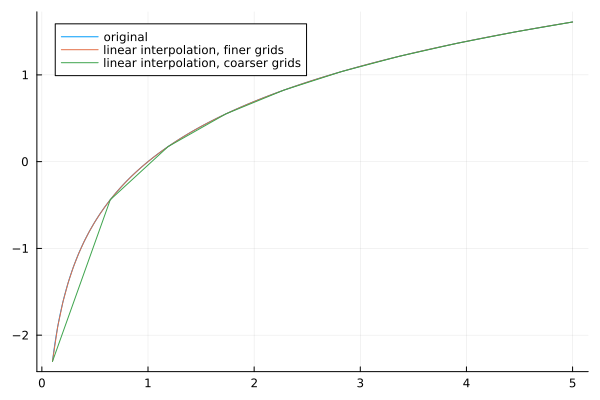

In [24]:
# check the accuracy of the interpolations
c_grid_lin_finer = LinRange(0.1, 5.0, 1000)
plot(c_grid_lin_finer, u1.(c_grid_lin_finer), label = "original")
plot!(c_grid_lin_finer, u1_lin_fine.(c_grid_lin_finer), label = "linear interpolation, finer grids")
plot!(c_grid_lin_finer, u1_lin_coarse.(c_grid_lin_finer), label = "linear interpolation, coarser grids")

From the graph, it is not hard to see that when the curvature is bigger, interpolating on the coarser grid gives visible numerical errors, while the finer grids perform better. 

We can also do higher orders of ***Spline Interpolations***. It allows you to get better functional approximation while making sure that the specified grid points are exactly reached.

Take cubic spline interpolations as example. Mathematically, it constructs a cubic polynomial $S_i(x)$ and finds $a_i, b_i ,c_i$ such that

$$
S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3,
$$
and $S_i(x_i) = y_i$, $S_i(x_{i+1}) = y_{i+1}$ and the first and second derivatives of $S_i(x)$ are continuous at each $x_i$.

Note that from the second condition, you see that higher-order interpolations are also powerful in obtaining numerical derivatives. Recall from the graph before, the function constructed from linear interpolation is continuous but generally not differentiable everywhere due to kinks at each grid points.

Let's see an example with cubic spline interpolation and compare it with the linear interpolation on the coarser grid.

In [25]:
u1_cubic_coarse = cubic_spline_interpolation(c_grid_lin_coarse, u1.(c_grid_lin_coarse));

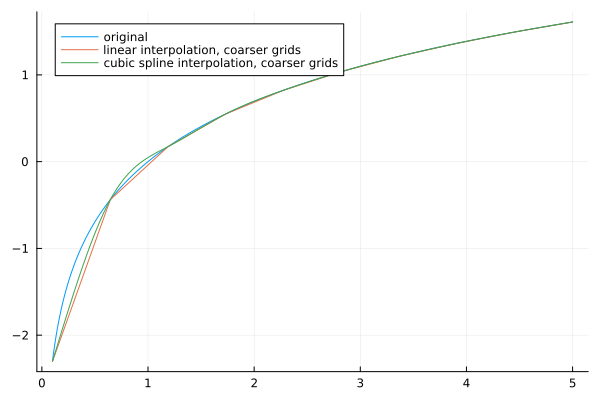

In [26]:
plot(c_grid_lin_finer, u1.(c_grid_lin_finer), label = "original")
plot!(c_grid_lin_finer, u1_lin_coarse.(c_grid_lin_finer), label = "linear interpolation, coarser grids")
plot!(c_grid_lin_finer, u1_cubic_coarse.(c_grid_lin_finer), label = "cubic spline interpolation, coarser grids")

You can see that cubic spline interpolation (green line) gives smaller errors compared to linear interpolations (red line). 

Of course, we are still left with plenty of errors and in reality you will want to use more grids for this.

#### 2.2 Peril of Interpolations

Now let's try one of economists' favorite function, the CRRA utility function (log is a special case) and do the same as before.

In [27]:
# the constant σ is the relative risk aversion
u2(c, σ) = c^(1.0 - σ)/(1.0 - σ)

u2 (generic function with 1 method)

In [28]:
σ = 2.0 # let the risk aversion be 2
u2_lin_coarse = linear_interpolation(c_grid_lin_coarse, u2.(c_grid_lin_coarse, Ref(σ))); # "Ref()" specifies that σ is a scalar and won't be broadcasted
u2_cubic_coarse = cubic_spline_interpolation(c_grid_lin_coarse, u2.(c_grid_lin_coarse, Ref(σ)));

In [29]:
u2_cubic_coarse(2.5)

-0.41019260074593517

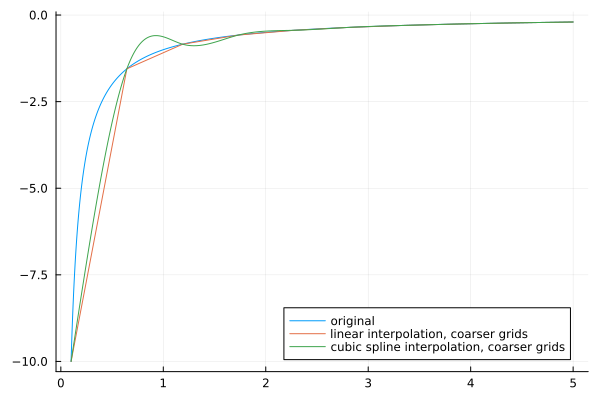

In [30]:
plot(c_grid_lin_finer, u2.(c_grid_lin_finer, Ref(σ)), label = "original")
plot!(c_grid_lin_finer, u2_lin_coarse.(c_grid_lin_finer), label = "linear interpolation, coarser grids")
plot!(c_grid_lin_finer, u2_cubic_coarse.(c_grid_lin_finer), label = "cubic spline interpolation, coarser grids")

***Think:*** 

* For both interpolations, when do they have larger errors and why (hint: what feature does $u''(c)$ have?)?
* For both interpolations, when does cubic spline interpolation has a larger error and why (hint: what feature does $S_i(x)$ have?)?

***Exercise:***

* Change $\sigma$ to 5 and 10 and do the same experiment. Try with both coarser and finer grids. How does the accuracy vary and what are the lessons?

### 3. Introduction to Continuous Optimization

Implementing optimization routines is simple in Julia with the help of nicely written packages. The hard part is to know to use the right method at the right time. There are hundreds of different routines out there and each is best suited for particular cases. Do you know the explicit form of the function? Is the function continuous? Is it concave/convex? Is it differentiable? Are there local maxes/mins? A big chunk of the machine/deep learning literature dedicates to this. The details of the topic is too broad to be covered by this short introduction but just keep in mind that there is no silver bullet of it.



#### 3.1 Unconstrained Optimization

Take the function we defined in section 1: $f(x, p) = -(x - p) ^ 2$. 

Given $p$, we want to find the maximum of the function. Obviously the correct result should again be $p$.

The standard package for optimization to use in Julia is [```Optim.jl```](https://julianlsolvers.github.io/Optim.jl/stable/user/minimization/), but you might also want to check [```NLopt.jl```](https://docs.sciml.ai/Optimization/stable/optimization_packages/nlopt/) and [```JuMP.jl```](https://jump.dev/JuMP.jl/stable/tutorials/getting_started/getting_started_with_JuMP/#Getting-started-with-JuMP). 
They each contain different methods and tackle different problems.

For the optimization routine, we will use LBFGS here, which is a quasi-Newton method. There are a bunch of other options. Check [here](https://julianlsolvers.github.io/Optim.jl/stable/user/config/) for more info.

In [31]:
using Optim # you have to add this package

In [32]:
f(x, p) = -(x[1] - p) ^ 2 #optimize take in vectors, here needs to specify x[1] for the first entry
result = optimize(x -> -f(x, 3.0), [0.0], LBFGS()) # set p to 3, need to negative as we are trying to maximize the function

 * Status: success

 * Candidate solution
    Final objective value:     1.502828e-21

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.00e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.99e+21 ≰ 0.0e+00
    |g(x)|                 = 7.75e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [33]:
# get the argmax
result.minimizer 

1-element Vector{Float64}:
 3.0000000000387663

In [34]:
# the abosulte error is
abs(result.minimizer[1] - 3.0)

3.8766323484651366e-11

Again here we can use Autodiff as we have a differentiable function with explicit form.

In [35]:
result = optimize(x -> -f(x, 3.0), [0.0], LBFGS(); autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     0.000000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.00e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = Inf ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [36]:
abs(result.minimizer[1] - 3.0)

0.0

Note that the accuracy improved by using automatic differentiation.

#### 3.2 Constrained Optimization

I rarely use quotes but here is a good one.

_"In economic theory, an agent is a constrained optimization problem. A model consists of a collection of constrained optimization problems.
Theories of general equilibrium, games, and macroeconomics acquire power by deploying an equilibrium concept whose role is to organize disparate choice problems by casting them within a coherent environment."_  
-- Thomas Sargent

Let's maximize the same function $f(x,3)$, but this time put an interval constraint on $x$, we will try $[2, 6]$ (which include the global max) and $[-2, 2]$ (which does not include the global max).

The syntax for optimization with a bounded interval is as follows
```
optimize(f, lower, upper, method; kwargs...)
```

I will use the [```Brent()```](https://en.wikipedia.org/wiki/Brent%27s_method) method for illustration. An alternative is to use [```GoldenSection()```](https://en.wikipedia.org/wiki/Golden-section_search#:~:text=The%20golden%2Dsection%20search%20is%20an%20efficient%20way%20to%20progressively,least%20value%20so%20far%20evaluated.).

In [37]:
optimize(x -> -f(x, 3.0), 2, 6, Brent())

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [2.000000, 6.000000]
 * Minimizer: 3.000000e+00
 * Minimum: 0.000000e+00
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6

In [38]:
optimize(x -> -f(x, 3.0), -2, 2, Brent())

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-2.000000, 2.000000]
 * Minimizer: 2.000000e+00
 * Minimum: 1.000000e+00
 * Iterations: 37
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 38

The Brent method gives correct answers in both cases, showing its robustness (and very fast). Beware some Quasi-Newton methods can fail in the second case as we do not reach $f'(x) = 0$ in the interval.

#### 3.3 Optimize an Interpolated Function

We have talked about the importance of continuos optimization. However, sometimes we don't know the exact functional form of which we are optimizing. Moreover, we might only know the value of our objective function at certain points. The example as you have seen in the last lecture, is the right hand side of the Bellman equation. 

This is where interpolation twines with continuous optimization. From the functional value at discrete grids, we first estimate the function by interpolation, then optimize it using continuous optimization. This is a standard routine in solving many economic models.

Again just for showcasing, we will maximize the same function, but let's pretend we only know its values at a discrete grid and need to approximate it with interpolations.

In [41]:
lingrid = LinRange(2.0, 6.0, 50);
f_val = -f.(lingrid, Ref(3.0)); # values of fx that we know
# need to extrapolate as unconstrained optimization requires value out of bounds
# consult the documentation of Interpolations.jl for details on extrapolations
f_interp = linear_interpolation(lingrid, f_val, extrapolation_bc = Line());

Let's check how well the interpolation does.

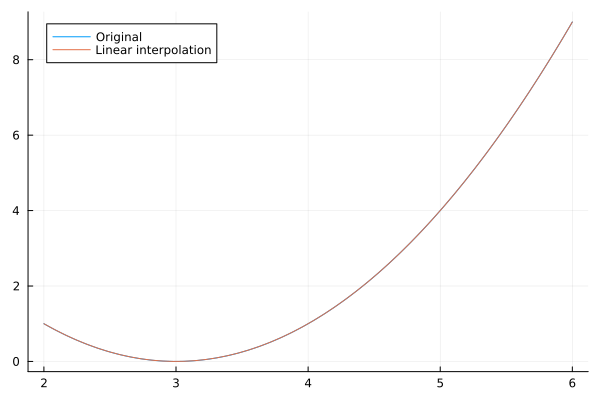

In [43]:
finer_grid = LinRange(2.0, 6.0, 500);
plot(finer_grid, -f.(finer_grid, Ref(3.0)), label = "Original")
plot!(finer_grid, f_interp.(finer_grid), label = "Linear interpolation")

The two lines seem to align perfectly, so we are good to go, right?

We can do unconstrained and constrained optimization as before. Although we can't use automatic differentiation anymore.

In [44]:
result1 = optimize(x -> f_interp(x[1]), [4.0], LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     4.168613e-04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.23e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.14e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.65e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.76e-05 ≰ 0.0e+00
    |g(x)|                 = 6.58e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    5
    f(x) calls:    20
    ∇f(x) calls:   20


In [45]:
result1.minimizer

1-element Vector{Float64}:
 2.979600858153335

In [46]:
result2 = optimize(f_interp, 2.0, 6.0, Brent())

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [2.000000, 6.000000]
 * Minimizer: 2.979592e+00
 * Minimum: 4.164937e-04
 * Iterations: 32
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 33

In [47]:
result2.minimizer

2.979591849606776

Pretty big errors of 0.02 (this can be big, say you miss the equilibrium interest rate by 2%)! How come?

Think about this for a bit yourself before reading forward.

Remember when using the original function, we obtained error that was close to 0. We didn't do anything different for the optimization routine, so it has to do with interpolation.

Go back to the thinking question in the last section and look at the graph of the function again. You shall be able to find the answer yourself.

If not, let's zoom in near the true maximization point (p):

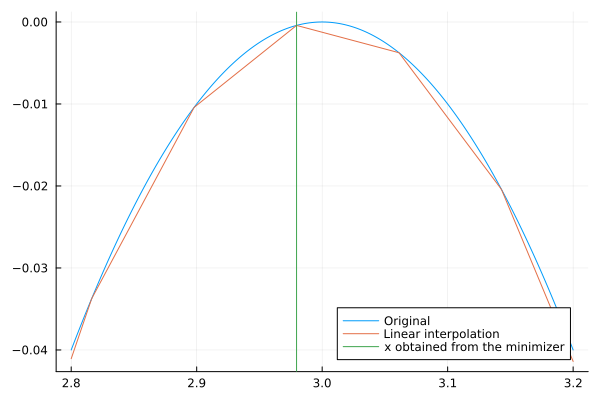

In [51]:
finer_grid_shrinked = LinRange(2.8, 3.2, 500);
plot(finer_grid_shrinked, f.(finer_grid_shrinked, Ref(3.0)), label = "Original")
plot!(finer_grid_shrinked, -f_interp.(finer_grid_shrinked), label = "Linear interpolation")
vline!([result2.minimizer], label = "x obtained from the minimizer", legend=:bottomright)

Your should wow when you see this the first time. 

In fact, the optimization package did exactly correct. It got the ***exact*** maximizer from your interpolated function. It is simply that the interpolated function is too biased around the maximizer due to high curvature around it.

Always keep in mind the peril of interpolation. It will save you enormous amount of time.

How to tackle this? More grid points and higher order of interpolations can help. Alternatively, you can ***put more points*** near where the ***curvature is high***.

Specify the following grid where there are 10 more points in the range of 2 to 4 and 10 less points from 4 to 6. Number of total points remain unchanged.

In [76]:
lingrid = vcat(collect(LinRange(2.0, 4.0, 35)), collect(LinRange(4.01, 6.0, 15))); #turn two linrange into vectors and combine them
f_val = -f.(lingrid, Ref(3.0)); # values of fx that we know
f_interp = linear_interpolation(lingrid, f_val, extrapolation_bc = false);

In [77]:
result2 = optimize(f_interp, 2.0, 6.0, Brent())

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [2.000000, 6.000000]
 * Minimizer: 3.000000e+00
 * Minimum: 9.262795e-10
 * Iterations: 20
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 21

In [78]:
result2.minimizer

2.9999999842532477

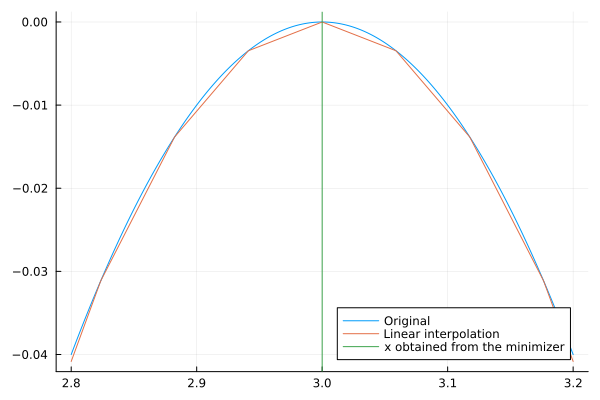

In [79]:
finer_grid_shrinked = LinRange(2.8, 3.2, 500);
plot(finer_grid_shrinked, f.(finer_grid_shrinked, Ref(3.0)), label = "Original")
plot!(finer_grid_shrinked, -f_interp.(finer_grid_shrinked), label = "Linear interpolation")
vline!([result2.minimizer], label = "x obtained from the minimizer", legend=:bottomright)

Much better results. This kind of tricks is widely used in economic applications. In practice, people often use power grids instead of linear grids.

In the homework, you will rewrite the neo-classical growth model you have seen in lecture 2 with continuous optimization. You will compare the performances and results.